<a href="https://colab.research.google.com/github/NehaSontakk/GCN-Metabolic-Pathways/blob/main/PML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import os
import glob
import json
import pandas as pd
import numpy as np
from math import log, exp


In [58]:
module_id      = "M00346"
sample_name    = "3300060297_1"

In [60]:
COMPLETENESS_CSV       = "/content/drive/MyDrive/Lab Work/Results_for_PNNL_March_2025/Contig_completeness.csv"
VK_CSV                 = "/content/drive/MyDrive/Lab Work/Results_for_PNNL_March_2025/KO_trusted_cutoff.csv"
KO_OCCURRENCES_TXT     = "/content/drive/MyDrive/Lab Work/Results_for_PNNL_March_2025/ko_occurences.txt"
ADJ_LINKS_JSON         = "/content/all_module_adjacency_links_Apr3.json"
neighbor_txt = "/content/ko_normalized_prediction.txt"
OUTPUT_EXCEL           = f"{module_id}_KO_table.xlsx"

In [59]:
MODULE_JSON_DIR = "/content/drive/MyDrive/Lab Work/Results_for_PNNL_March_2025/Graph_Generation/KEGG_Graphs_Generated"
nodes_path = f"{MODULE_JSON_DIR}/module_{module_id}_nodes.json"
with open(nodes_path) as f:
    module_nodes = json.load(f)

# Extract just the KO IDs in this module (base 6‐char codes)
module_kos = sorted({n.split("_",1)[0] for n in module_nodes if n.startswith("K")})


## Preparing tables for dk values for each KO

In [61]:
# completeness
df_comp = pd.read_csv(COMPLETENESS_CSV)
df_comp['sigma'] = 1 - ((np.exp(3 * df_comp['Completeness']) - 1) / np.exp(3))

# VK table
df_vk = pd.read_csv(VK_CSV)
df_vk['E_values_MAG']    = df_vk['E_values_MAG'].fillna(1e4)
df_vk['E_value_trusted'] = df_vk['E_value_trusted'].fillna(1e-5)
df_vk['Rk']   = df_vk['E_values_MAG'] / df_vk['E_value_trusted']
df_vk['Vk']   = df_vk['Rk'].apply(lambda x: max(0, -np.log10(x)))
df_vk['alphak'] = df_vk['Vk'].apply(lambda x: 1 - np.exp(-x / 5))
df_vk['q_half'] = df_vk['E_value_trusted'] * (10 ** -3.46574)


<ipython-input-61-41ea7be3629f>:10: RuntimeWarning: divide by zero encountered in log10
  df_vk['Vk']   = df_vk['Rk'].apply(lambda x: max(0, -np.log10(x)))


In [62]:
# merge in KO frequencies
ko_occ = pd.read_csv(KO_OCCURRENCES_TXT, sep="\s+",names=['KO id','occurences'])
ko_occ['KO_freq'] = ko_occ['occurences'] / 895

df_vk_prob = pd.merge(df_vk, ko_occ, on="KO id", how="left")
df_vk_prob['KO_freq'] = df_vk_prob['KO_freq'].fillna(1e-3)

# pick sigma for your sample
sigma_val = df_comp.loc[df_comp['filename']==sample_name, 'sigma'].iloc[0]

### γₖ FUNCTION & Dₖ CALC

In [63]:
def gamma_func(row, t=np.float128(1e-5)):
    q = np.float128(row['E_value_trusted'])
    mag = np.float128(row['E_values_MAG'])
    qh = q * (np.float128(10) ** np.float128(-3.46574))
    α = np.float128(row['alphak'])
    if mag > t:
        return np.float128(0)
    elif mag > qh:
        return (np.log10(mag/t) / np.log10(qh/t)) * np.float128(0.5)
    else:
        return α

df_vk_prob['gamma_k'] = df_vk_prob.apply(gamma_func, axis=1)
df_vk_prob['Dk'] = df_vk_prob.apply(
    lambda r: r['gamma_k'] + (1 - r['gamma_k']) * sigma_val * r['KO_freq'],
    axis=1
)
df_vk_prob['sigma'] = sigma_val

<ipython-input-63-f96ea9149f91>:9: RuntimeWarning: divide by zero encountered in log10
  return (np.log10(mag/t) / np.log10(qh/t)) * np.float128(0.5)


In [64]:
nodes_path = os.path.join(MODULE_JSON_DIR, f"module_{module_id}_nodes.json")
with open(nodes_path) as f:
    module_nodes = json.load(f)

# build lookup
dk_dict = dict(zip(df_vk_prob['KO id'], df_vk_prob['Dk']))

module_nodes_with_DK = {}
for node, idx in module_nodes.items():
    if node.startswith("K"):
        base = node.split("_",1)[0]
        module_nodes_with_DK[node] = {
            "index": idx,
            "Dk": dk_dict.get(base, np.nan)
        }
    else:
        module_nodes_with_DK[node] = {"index": idx}

In [65]:
ko_set = {n.split("_",1)[0] for n in module_nodes if n.startswith("K")}
print(ko_set)
missing_kos = ko_set.difference(df_vk_prob['KO id'])

if missing_kos:
    # constant pieces we’ll reuse
    _defaults = {
        "E_value_trusted": 1e-5,
        "E_values_MAG":    1e4,
        "KO_freq":         1e-3,
        "sigma":           sigma_val        # use the same σ for this sample
    }

    new_rows = []
    for ko in missing_kos:
        # recompute the derived columns exactly the same way
        Rk       = _defaults["E_values_MAG"] / _defaults["E_value_trusted"]
        Vk       = max(0, -np.log10(Rk))
        alphak   = 1 - np.exp(-Vk / 5)
        q_half   = _defaults["E_value_trusted"] * (10 ** -3.46574)

        # γ_k with the same rules as `gamma_func`
        t        = np.float128(1e-5)
        mag128   = np.float128(_defaults["E_values_MAG"])
        qh128    = np.float128(q_half)
        if mag128 > t:
            gamma_k = 0.0                     # falls into the first branch of gamma_func
        elif mag128 > qh128:
            gamma_k = (np.log10(mag128/t) / np.log10(qh128/t)) * 0.5
        else:
            gamma_k = alphak

        # finally D_k
        Dk = gamma_k + (1 - gamma_k) * sigma_val * _defaults["KO_freq"]

        new_rows.append({
            "KO id": ko,
            "E_value_trusted": _defaults["E_value_trusted"],
            "E_values_MAG":    _defaults["E_values_MAG"],
            "Rk":              Rk,
            "Vk":              Vk,
            "alphak":          alphak,
            "q_half":          q_half,
            "gamma_k":         gamma_k,
            "KO_freq":         _defaults["KO_freq"],
            "sigma":           sigma_val,
            "Dk":              Dk
        })

    # append to the main probability table
    df_vk_prob = pd.concat([df_vk_prob, pd.DataFrame(new_rows)],
                           ignore_index=True)

{'K08692', 'K08691', 'K00024', 'K11529', 'K01595', 'K00830', 'K00018', 'K14067', 'K01689', 'K00600'}


In [66]:
filtered = df_vk_prob[df_vk_prob['KO id'].isin(ko_set)]
cols = ['KO id','E_value_trusted','E_values_MAG','Rk','Vk',
        'alphak','q_half','gamma_k','KO_freq','sigma','Dk']
filtered[cols].to_excel(OUTPUT_EXCEL, index=False)
print(f"KO table written to {OUTPUT_EXCEL}")

→ KO table written to M00346_KO_table.xlsx


In [67]:
filtered[cols]

,KO id,E_value_trusted,E_values_MAG,Rk,Vk,alphak,q_half,gamma_k,KO_freq,sigma,Dk
897,K14067,1.000000e-05,6.500000e-67,6.500000e-62,61.187087,0.999995,3.421842e-09,0.999995,0.001000,0.712293,0.999995
2953,K01689,4.744747e-77,2.900000e-199,6.112022e-123,122.213815,1.000000,1.623578e-80,1.000000,0.998883,0.712293,1.000000
5910,K00018,1.000000e-05,7.500000e-62,7.500000e-57,56.124939,0.999987,3.421842e-09,0.999987,0.258101,0.712293,0.999989
6198,K00024,1.000000e-05,1.800000e-122,1.800000e-117,116.744727,1.000000,3.421842e-09,1.000000,0.278212,0.712293,1.000000
6437,K00600,2.746448e-20,1.900000e-190,6.918027e-171,170.160018,1.000000,9.397912e-24,1.000000,0.993296,0.712293,1.000000
6976,K08692,8.065381e-141,1.100000e-120,1.363854e+20,0.000000,0.000000,2.759846e-144,0.414836,0.001000,0.712293,0.415253
10207,K08691,1.000000e-05,2.900000e-02,2.900000e+03,0.000000,0.000000,3.421842e-09,0.000000,0.006704,0.712293,0.004775
15671,K00830,1.000000e-05,1.500000e-27,1.500000e-22,21.823909,0.987283,3.421842e-09,0.987283,0.051397,0.712293,0.987748
17751,K01595,7.090557e-13,1.600000e-183,2.256522e-171,170.646560,1.000000,2.426277e-16,1.000000,0.613408,0.712293,1.000000
24273,K11529,1.380986e-45,1.000000e+04,7.241201e+48,0.000000,0.000000,4.725518e-49,0.000000,0.083799,0.712293,0.059689


### Path probabilities

In [68]:
def compute_path_probability(path, dk_dict):
    """Return Π Dk over all KO‑nodes in the path."""
    prob = np.float128(1.0)
    for node in path:
        if '_' in node:
            koid = node.split('_', 1)[0]
            prob *= np.float128(dk_dict.get(koid, 1.0))
    return prob

def score_path(path, dk_dict, *, alpha=0.6):
    """
    Compute three normalised scores for a single path:
      • log‑probability sum                 (LogP)
      • average (per‑step) log‑probability  (AvgLogP)
      • length‑penalised log‑probability    (LenPen)
    Returns a dict with raw prob too.
    """
    raw_p = compute_path_probability(path, dk_dict)      # 0 < raw_p ≤ 1
    L = sum(1 for n in path if 'K' in n)                 # # of KO nodes

    if raw_p == 0:                                       # defensive
        log_p        = -np.inf
        avg_log_p    = -np.inf
        lenpen_score = -np.inf
    else:
        log_p        = float(np.log(raw_p))              # natural‑log domain
        avg_log_p    = log_p / L                         # geometric‑mean normalisation
        lenpen_score = log_p / (L ** alpha)              # Google‑style length penalty

    return {
        "L": L,
        "raw_prob"       : float(raw_p),                 # still handy to keep
        "log_prob"       : log_p,                        # Σ log pᵢ
        "avg_log_prob"   : avg_log_p,                    # (Σ log pᵢ)/L
        "geo_mean_prob"  : exp(avg_log_p),               # e^{AvgLogP}
        "lenpen_score"   : lenpen_score                  # Σ log pᵢ / L^α
    }

paths_path = os.path.join(MODULE_JSON_DIR, f"module_{module_id}_paths.json")
with open(paths_path) as f:
    paths_dict = json.load(f)


rows_og = []
for key, comma_str in sorted(paths_dict.items(), key=lambda x: int(x[0])):
    path_nodes = [n.strip() for n in comma_str.split(',')]
    sc         = score_path(path_nodes, dk_dict)
    rows_og.append({
        "path_id":      int(key),
        "path":         " -> ".join(path_nodes),
        "raw_prob":     sc["raw_prob"],
        "avg_log_prob": sc["avg_log_prob"],
        "geo_mean_prob":sc["geo_mean_prob"],
        "lenpen_score": sc["lenpen_score"],
    })

df_path_before_diffusion = (
    pd.DataFrame(rows_og)
      .set_index("path_id")      # optional—keeps the original numbering
      .sort_index()
)

'''
for key, comma_str in sorted(paths_dict.items(), key=lambda x:int(x[0])):
    path = [n.strip() for n in comma_str.split(',')]
    #print(path)
    sc = score_path(path, dk_dict)
    print(f"Path {key}: {' -> '.join(path)}")
    print("  raw_prob:",    f"{sc['raw_prob']:.6f}")
    print("  avg_log_prob:", f"{sc['avg_log_prob']:.4f}")
    print("  geo_mean_prob:",f"{sc['geo_mean_prob']:.6f}")
    print("  lenpen_score:", f"{sc['lenpen_score']:.4f}")
    #print(f"Path {key}: raw={sc['raw']:.4e}, avg_log={sc['avg_log']:.4f}, lenpen={sc['lenpen']:.4f}")
'''

df_path_before_diffusion.sort_values(by="geo_mean_prob",ascending=False)

,path,raw_prob,avg_log_prob,geo_mean_prob,lenpen_score
path_id,,,,,
1,K00600_1 -> K00830_2 -> K00018_3 -> K11529_4 -...,0.000117,-0.905414,0.404374,-2.274298


In [69]:
neighbors = {}

with open(neighbor_txt, 'r') as f:
    for line in f:
        line = line.strip()
        if not line or not line.startswith("K"):
            continue
        # KO:id:index: neighbor1:weight, neighbor2:weight, ...
        ko, idx, nbrs_str = line.split(":", 2)
        ko = ko.strip()
        entries = [e.strip() for e in nbrs_str.split(",") if e.strip()]
        nbr_list = []
        for entry in entries:
            nbr_id, weight_str = entry.split(":")
            w = float(weight_str)
            # clamp zero weights to 0.001
            if w == 0.0:
                w = 0.001
            nbr_list.append((nbr_id.strip(), w))
        neighbors[ko] = nbr_list


In [70]:
dk_dict = dict(zip(df_vk_prob['KO id'], df_vk_prob['Dk']))

In [71]:
neighbors.get('K00844',0)

[('K01835', 1.0),
 ('K12406', 0.001),
 ('K15635', 0.65),
 ('K01834', 1.0),
 ('K13810', 0.001),
 ('K00873', 0.78),
 ('K24182', 0.001),
 ('K15633', 0.65),
 ('K11389', 0.001),
 ('K01810', 1.0),
 ('K15778', 0.001),
 ('K27394', 0.001),
 ('K00918', 0.001),
 ('K00134', 1.0),
 ('K00886', 0.001),
 ('K15779', 0.001),
 ('K01623', 0.001),
 ('K00972', 0.13),
 ('K12447', 0.001),
 ('K16370', 0.001),
 ('K01624', 1.0),
 ('K01803', 1.0),
 ('K12407', 0.001),
 ('K25026', 0.65),
 ('K00150', 0.001),
 ('K00850', 0.78),
 ('K00963', 0.13),
 ('K00927', 1.0),
 ('K11645', 0.65),
 ('K15916', 0.001),
 ('K08074', 0.001),
 ('K00820', 0.78),
 ('K06859', 0.001),
 ('K00845', 0.001),
 ('K21071', 0.65),
 ('K00621', 0.13),
 ('K01836', 0.001),
 ('K01689', 1.0),
 ('K16305', 0.001),
 ('K16306', 0.001),
 ('K15634', 0.001)]

In [72]:
alpha = 0.6
records = []
for ko in module_kos:
    old_p = dk_dict.get(ko, np.nan)
    nbrs  = neighbors.get(ko, [])
    # unpack
    nbr_ids = [u for u,_ in nbrs]
    wts     = [w for _,w in nbrs]
    dks     = [dk_dict.get(u,0.0) for u in nbr_ids]

    #neighbor trust
    print(max(wts))
    T = alpha*max(wts)
    print(T)

    # GCN
    num = sum(w*d for w,d in zip(wts,dks))
    den = sum(wts) or 1.0
    raw_gcn = (1-T)*old_p + T*(num/den)
    new_gcn = max(old_p, raw_gcn)

    records.append({
        'KO id':                 ko,
        'Dk for KO':             old_p,
        'Neighbors':             nbrs,
        'Weights':               wts,
        'Dk for each neighbor':  [f'{d:0.4f}' for d in dks],
        'Calculated GCN': raw_gcn,
        'Final GCN':             new_gcn
    })

1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
1.0
0.6
0.001
0.0006
1.0
0.6
0.001
0.0006


In [73]:
df_gcn = pd.DataFrame(records)

In [74]:
df_gcn

,KO id,Dk for KO,Neighbors,Weights,Dk for each neighbor,Calculated GCN,Final GCN
0,K00018,0.999989,"[(K01595, 0.61), (K11529, 0.11), (K01689, 1.0)...","[0.61, 0.11, 1.0, 0.001, 0.13, 0.13, 1.0, 0.00...","[1.0000, 0.0597, 1.0000, 0.0048, 0.9877, 1.000...",0.978553,0.999989
1,K00024,1.000000,"[(K01679, 0.96), (K15017, 0.001), (K15038, 0.0...","[0.96, 0.001, 0.001, 0.41, 0.94, 0.001, 0.73, ...","[0.5380, 0.0255, 1.0000, 0.1846, 1.0000, 0.948...",0.820821,1.000000
2,K00600,1.000000,"[(K01601, 0.001), (K13403, 0.001), (K11529, 0....","[0.001, 0.001, 0.08, 0.74, 0.001, 0.01, 0.001,...","[0.0007, 1.0000, 0.0597, 1.0000, 0.9942, 0.004...",0.936762,1.000000
3,K00830,0.987748,"[(K01601, 0.001), (K11529, 0.15), (K03781, 0.8...","[0.001, 0.15, 0.85, 0.001, 0.02, 0.001, 0.001,...","[0.0007, 0.0597, 1.0000, 0.9942, 0.0048, 0.933...",0.947039,0.987748
4,K01595,1.000000,"[(K00239, 0.88), (K18557, 0.001), (K14465, 0.0...","[0.88, 0.001, 0.001, 0.86, 0.11, 0.1, 0.01, 0....","[1.0000, 0.0891, 0.9988, 0.6759, 0.0597, 0.184...",0.837702,1.000000
5,K01689,1.000000,"[(K12406, 0.001), (K15635, 0.03), (K01086, 0.0...","[0.001, 0.03, 0.001, 0.77, 0.08, 0.01, 0.001, ...","[1.0000, 0.0247, 1.0000, 0.9789, 0.0597, 0.004...",0.923640,1.000000
6,K08691,0.004775,"[(K00023, 1.0), (K14468, 0.001), (K00239, 1.0)...","[1.0, 0.001, 1.0, 0.001, 0.17, 1.0, 1.0, 1.0, ...","[1.0000, 0.0007, 1.0000, 0.3557, 0.0597, 1.000...",0.388507,0.388507
7,K08692,0.415253,"[(K01595, 0.001), (K11529, 0.001), (K01689, 0....","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...","[1.0000, 0.0597, 1.0000, 0.0048, 0.9877, 1.000...",0.415474,0.415474
8,K11529,0.059689,"[(K01595, 0.8), (K01689, 1.0), (K08691, 0.01),...","[0.8, 1.0, 0.01, 0.09, 0.37, 0.35, 1.0, 0.001,...","[1.0000, 1.0000, 0.0048, 0.9877, 1.0000, 1.000...",0.621947,0.621947
9,K14067,0.999995,"[(K01595, 0.001), (K11529, 0.001), (K01689, 0....","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...","[1.0000, 0.0597, 1.0000, 0.0048, 0.9877, 1.000...",0.999826,0.999995


In [32]:
df_gcn.to_excel("gcn_all_n.xlsx")

### GCN path probabilities

In [33]:
gcn_dict = dict(zip(df_gcn['KO id'], df_gcn['Final GCN']))

In [34]:
rows = []
for key in sorted(paths_dict, key=lambda x: int(x)):
    path_nodes = [n.strip() for n in paths_dict[key].split(',')]
    sc         = score_path(path_nodes, gcn_dict)          # returns dict of scores
    rows.append({
        "path_id":      int(key),
        "path":         " -> ".join(path_nodes),
        "raw_prob":     sc["raw_prob"],
        "avg_log_prob": sc["avg_log_prob"],
        "geo_mean_prob":sc["geo_mean_prob"],
        "lenpen_score": sc["lenpen_score"],
    })

df_paths = (
    pd.DataFrame(rows)
      .set_index("path_id")
      .sort_index()
)


In [35]:
df_paths.sort_values(by="geo_mean_prob",ascending=False).to_excel("paths_post_gcn.xlsx")

In [36]:
df_paths.to_excel("paths_post_gcn.xlsx")

In [37]:
for key in sorted(paths_dict, key=lambda x: int(x)):
    path = [n.strip() for n in paths_dict[key].split(',')]
    sc   = score_path(path, gcn_dict)
    print(f"Path {key}: {' -> '.join(path)}")
    print("  raw_prob:",    f"{sc['raw_prob']:.6f}")
    print("  avg_log_prob:", f"{sc['avg_log_prob']:.4f}")
    print("  geo_mean_prob:",f"{sc['geo_mean_prob']:.6f}")
    print("  lenpen_score:", f"{sc['lenpen_score']:.4f}")

Path 1: K01906_1 -> K00652_2 -> K00833_3 -> K01935_5 -> K01012_6
  raw_prob: 0.588241
  avg_log_prob: -0.1061
  geo_mean_prob: 0.899313
  lenpen_score: -0.2020
Path 2: K01906_1 -> K00652_2 -> K19563_4 -> K01935_5 -> K01012_6
  raw_prob: 0.284701
  avg_log_prob: -0.2513
  geo_mean_prob: 0.777817
  lenpen_score: -0.4783


In [38]:
nor_records = []
for ko in module_kos:
    old_p = dk_dict.get(ko, np.nan)
    nbrs  = neighbors.get(ko, [])
    # unpack
    nbr_ids = [u for u,_ in nbrs]
    wts     = [w for _,w in nbrs]
    dks     = [dk_dict.get(u,0.0) for u in nbr_ids]


    fail_current_ko = (1-old_p)
    print(fail_current_ko)

    fail_all = fail_current_ko
    for w,d in zip(wts,dks):
      fail_all *= (1 - w*d)
    print(fail_all)
    raw_no = 1 - fail_all

    nor_records.append({
        'KO id':                 ko,
        'Dk for KO':             old_p,
        'Neighbors':             nbrs,
        'Weights':               wts,
        'Dk for each neighbor':  dks,
        'New Dk NoisyOR':        raw_no
    })


df_nor = pd.DataFrame(nor_records)

8.712364163443453435e-12
4.323818848690732497e-15
0.0024248301161259311343
7.120882413426309085e-16
4.9161008597309319157e-11
1.9918796035455077478e-13
0.9641863930681154951
6.0294494910556435773e-15
0.012347649333683485828
7.157376338554959386e-15
0.81405396256349366046
9.421623432492319166e-27


In [39]:
df_nor

,KO id,Dk for KO,Neighbors,Weights,Dk for each neighbor,New Dk NoisyOR
0,K00652,1.000000,"[(K01906, 0.05), (K00833, 0.89), (K01935, 0.9)...","[0.05, 0.89, 0.9, 0.01, 0.001, 0.01, 0.96, 0.001]","[0.03581360693188450489, 0.9975751698838740688...",1.0
1,K00833,0.997575,"[(K01906, 0.07), (K00652, 0.73), (K01935, 0.99...","[0.07, 0.73, 0.99, 0.01, 1.0, 0.001]","[0.03581360693188450489, 0.9999999999912876358...",1.0
2,K01012,1.000000,"[(K01906, 0.06), (K00833, 0.88), (K00652, 0.7)...","[0.06, 0.88, 0.7, 0.9, 0.01, 0.001, 0.01, 0.001]","[0.03581360693188450489, 0.9975751698838740688...",1.0
3,K01906,0.035814,"[(K00833, 0.98), (K00652, 0.53), (K01935, 1.0)...","[0.98, 0.53, 1.0, 0.11, 1.0]","[0.99757516988387406887, 0.9999999999912876358...",1.0
4,K01935,0.987652,"[(K01906, 0.07), (K00833, 0.96), (K00652, 0.72...","[0.07, 0.96, 0.72, 0.01, 0.001, 0.01, 1.0, 0.001]","[0.03581360693188450489, 0.9975751698838740688...",1.0
5,K19563,0.185946,"[(K01906, 1.0), (K00833, 1.0), (K00652, 1.0), ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.001]","[0.03581360693188450489, 0.9975751698838740688...",1.0


In [40]:
df_nor.to_excel("nor_df.xlsx")

### Noisy OR with path probabilities

In [41]:
nor_dict = dict(zip(df_nor['KO id'], df_nor['New Dk NoisyOR']))

In [42]:
for key in sorted(paths_dict, key=lambda x: int(x)):
    path = [n.strip() for n in paths_dict[key].split(',')]
    sc   = score_path(path, nor_dict)
    print(f"Path {key}: {' -> '.join(path)}")
    print("  raw_prob:",    f"{sc['raw_prob']:.6f}")
    print("  avg_log_prob:", f"{sc['avg_log_prob']:.4f}")
    print("  geo_mean_prob:",f"{sc['geo_mean_prob']:.6f}")
    print("  lenpen_score:", f"{sc['lenpen_score']:.4f}")

Path 1: K01906_1 -> K00652_2 -> K00833_3 -> K01935_5 -> K01012_6
  raw_prob: 1.000000
  avg_log_prob: -0.0000
  geo_mean_prob: 1.000000
  lenpen_score: -0.0000
Path 2: K01906_1 -> K00652_2 -> K19563_4 -> K01935_5 -> K01012_6
  raw_prob: 1.000000
  avg_log_prob: -0.0000
  geo_mean_prob: 1.000000
  lenpen_score: -0.0000


In [43]:
import os
import glob
import json
import pandas as pd
import numpy as np
from math import log, exp

# ──────────────────────────────────────────────────────────────────────────────
# (1) -- everything up to and including the construction of `df_vk_prob` and
#         the global `dk_dict` and `neighbors` dicts stays exactly the same
#
#    [ your existing code that builds df_comp, df_vk, df_vk_prob, gamma_k,
#      Dk, then loads `neighbors` into a dict ]
#
#    At the end of that section you should have:
#      - `dk_dict`  : KO id → Dk before GCN
#      - `neighbors`: KO id → list of (neighbor_id, weight)
# ──────────────────────────────────────────────────────────────────────────────


# helper scoring function (unchanged)
def compute_path_probability(path, dk_map):
    p = np.float128(1.0)
    for node in path:
        if '_' in node:
            ko = node.split('_',1)[0]
            p *= np.float128(dk_map.get(ko, 1.0))
    return p

def score_path(path, dk_map, *, alpha=0.6):
    raw_p = compute_path_probability(path, dk_map)
    L = sum(1 for n in path if 'K' in n)
    if raw_p == 0:
        return {"raw_prob": 0.0}
    log_p = float(np.log(raw_p))
    avg_log = log_p / L
    geo_mean = exp(avg_log)
    lenpen = log_p / (L ** alpha)
    return {
        "raw_prob": raw_p,
        "avg_log_prob": avg_log,
        "geo_mean_prob": geo_mean,
        "lenpen_score": lenpen
    }

# ──────────────────────────────────────────────────────────────────────────────
# (2) Loop over every module_*_paths.json in your KEGG_Graphs_Generated folder
# ──────────────────────────────────────────────────────────────────────────────

MODULE_JSON_DIR = "/content/drive/MyDrive/Lab Work/Results_for_PNNL_March_2025/Graph_Generation/KEGG_Graphs_Generated"
paths_files = glob.glob(os.path.join(MODULE_JSON_DIR, "module_*_paths.json"))

all_rows = []

for paths_fp in paths_files:
    # extract module_id, e.g. "M00010"
    module_id = os.path.basename(paths_fp).split("_")[1]

    # load paths
    with open(paths_fp) as f:
        paths_dict = json.load(f)

    # load module nodes to find which KOs belong to it
    nodes_fp = os.path.join(MODULE_JSON_DIR, f"module_{module_id}_nodes.json")
    with open(nodes_fp) as f:
        module_nodes = json.load(f)
    module_kos = sorted({n.split("_",1)[0]
                         for n in module_nodes
                         if n.startswith("K")})

    # --- compute GCN‐updated Dk just for this module’s KOs ---
    alpha = 0.6
    gcn_map = {}
    for ko in module_kos:
        old_p = dk_dict.get(ko, np.nan)
        nbrs  = neighbors.get(ko, [])
        wts   = [w for _,w in nbrs]
        dks   = [dk_dict.get(u, 0.0) for u,_ in nbrs]

        T = alpha * (max(wts) if wts else 0.0)
        num = sum(w*d for w,d in zip(wts, dks))
        den = sum(wts) or 1.0
        raw_gcn = (1 - T)*old_p + T*(num/den)
        gcn_map[ko] = max(old_p, raw_gcn)

    # --- for each path, score before and after GCN and append to master list ---
    for key, comma_str in sorted(paths_dict.items(), key=lambda x: int(x[0])):
        path_nodes = [n.strip() for n in comma_str.split(',')]
        sb = score_path(path_nodes, dk_dict)
        sa = score_path(path_nodes, gcn_map)

        all_rows.append({
            "module_id":           module_id,
            "path_id":             int(key),
            "path":                " -> ".join(path_nodes),
            "raw_prob_before_gcn": sb["raw_prob"],
            "raw_prob_after_gcn":  sa["raw_prob"],
            # if you want more metrics, add e.g.:
            # "geo_mean_before": sb["geo_mean_prob"],
            # "geo_mean_after":  sa["geo_mean_prob"],
        })

# ──────────────────────────────────────────────────────────────────────────────
# (3) Build your DataFrame and save or return it
# ──────────────────────────────────────────────────────────────────────────────

df_all = pd.DataFrame(all_rows)

# e.g. write to Excel or CSV:
df_all.to_excel("all_modules_paths_gcn_comparison.xlsx", index=False)

# now `df_all` has one row per module–path with before/after GCN probabilities
print(df_all.head())


  module_id  path_id                                               path  \
0    M00615        1  K15576_2 -> K15577_3 -> K15578_4 -> K15579_5 -...   
1    M00615        2  K15576_2 -> K15577_3 -> K15578_4 -> K15579_5 -...   
2    M00615        3  K15576_2 -> K15577_3 -> K15578_4 -> K15579_5 -...   
3    M00615        4  K15576_2 -> K15577_3 -> K15578_4 -> K15579_5 -...   
4    M00615        5  K15576_2 -> K15577_3 -> K15578_4 -> K00367_6 -...   

   raw_prob_before_gcn  raw_prob_after_gcn  
0         1.380487e-06        1.550160e-05  
1         2.776398e-04        3.418799e-03  
2         2.551061e-09        2.885130e-08  
3         4.932213e-07        6.116934e-06  
4         1.381076e-06        1.550822e-05  


Wasserstein distance: 3.8947e+03
KL divergence (KL(p||q)): 8.4380e+00


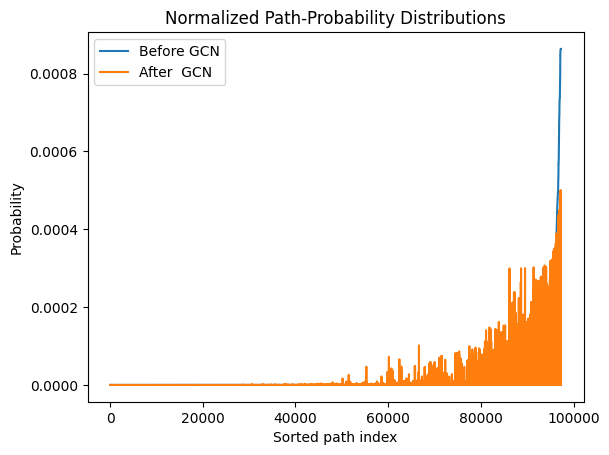

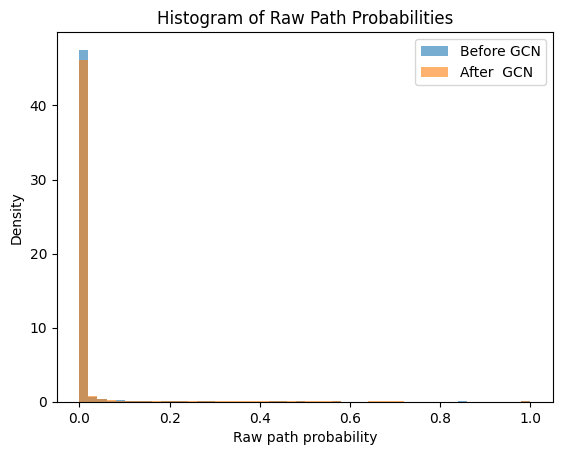

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, entropy

# 1. pull in your raw columns and coerce to floats
before = df_all['raw_prob_before_gcn'].astype(float).values
after  = df_all['raw_prob_after_gcn'].astype(float).values

# 2. clean any NaNs or Infs by turning them into zeros
before = np.nan_to_num(before, nan=0.0, posinf=0.0, neginf=0.0)
after  = np.nan_to_num(after,  nan=0.0, posinf=0.0, neginf=0.0)

# 3. tiny floor to avoid pure zeros
eps = 1e-12
before += eps
after  += eps

# 4. confirm sums are positive
sum_b = before.sum()
sum_a = after.sum()
if not (np.isfinite(sum_b) and sum_b > 0):
    raise ValueError(f"Before‐GCN sum is invalid: {sum_b}")
if not (np.isfinite(sum_a) and sum_a > 0):
    raise ValueError(f"After‐GCN sum is invalid: {sum_a}")

# 5. normalize into pmfs
p = before / sum_b
q = after  / sum_a

# 6. compute distances
locations = np.arange(len(p))
w_dist = wasserstein_distance(locations, locations, u_weights=p, v_weights=q)
kl_div  = entropy(p, q)   # D_KL(p || q)

print(f"Wasserstein distance: {w_dist:.4e}")
print(f"KL divergence (KL(p||q)): {kl_div:.4e}")

# 7. plotting
# 7a) sorted‐pmf line plot
idx = np.argsort(p)
plt.figure()
plt.plot(p[idx], label='Before GCN')
plt.plot(q[idx], label='After  GCN')
plt.xlabel("Sorted path index")
plt.ylabel("Probability")
plt.legend()
plt.title("Normalized Path-Probability Distributions")
plt.show()

# 7b) histograms of the raw (pre‐eps) probabilities
plt.figure()
plt.hist(before - eps, bins=50, density=True, alpha=0.6, label='Before GCN')
plt.hist(after  - eps, bins=50, density=True, alpha=0.6, label='After  GCN')
plt.xlabel("Raw path probability")
plt.ylabel("Density")
plt.title("Histogram of Raw Path Probabilities")
plt.legend()
plt.show()


Wasserstein-1 distance: 3894.708537
Kullback-Leibler divergence: 8.437993


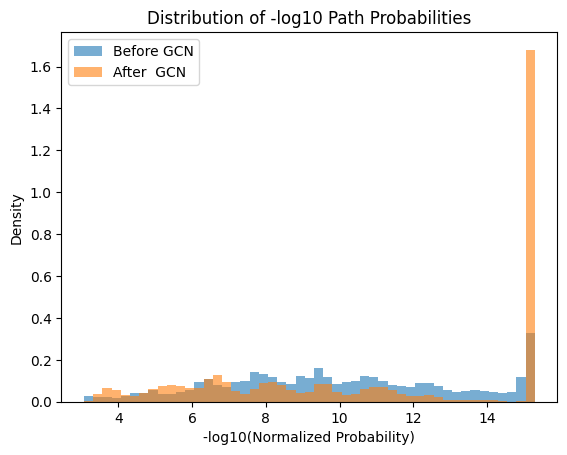

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, entropy

# Assumes `df_all` is already defined in your notebook:

# 1) Extract and clean
before = df_all['raw_prob_before_gcn'].astype(float).to_numpy()
after  = df_all['raw_prob_after_gcn'].astype(float).to_numpy()
before = np.nan_to_num(before, nan=0.0, posinf=0.0, neginf=0.0)
after  = np.nan_to_num(after,  nan=0.0, posinf=0.0, neginf=0.0)

# 2) Add eps and normalize to PMF
eps = 1e-12
before += eps
after  += eps
p = before / before.sum()
q = after  / after.sum()

# 3) Compute distances
positions = np.arange(len(p))
w1 = wasserstein_distance(positions, positions, u_weights=p, v_weights=q)
kl = entropy(p, q)

print(f"Wasserstein-1 distance: {w1:.6f}")
print(f"Kullback-Leibler divergence: {kl:.6f}")

# 4) Histogram of -log10(p) and -log10(q)
log_p = -np.log10(p)
log_q = -np.log10(q)

plt.figure()
bins = np.linspace(min(log_p.min(), log_q.min()), max(log_p.max(), log_q.max()), 50)
plt.hist(log_p, bins=bins, density=True, alpha=0.6, label='Before GCN')
plt.hist(log_q, bins=bins, density=True, alpha=0.6, label='After  GCN')
plt.xlabel("-log10(Normalized Probability)")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of -log10 Path Probabilities")
plt.show()


In [46]:
import pandas as pd

# 1) Coerce to numeric (if not already) and drop any NaNs
df_all['raw_prob_before_gcn'] = pd.to_numeric(df_all['raw_prob_before_gcn'], errors='coerce')
df_all['raw_prob_after_gcn']  = pd.to_numeric(df_all['raw_prob_after_gcn'], errors='coerce')
df_clean = df_all.dropna(subset=['raw_prob_before_gcn','raw_prob_after_gcn'])
df_clean['raw_prob_before_gcn'] = pd.to_numeric(
    df_clean['raw_prob_before_gcn'], errors='coerce'
).astype(float)

# 2) For each module, get the index of the max-before and max-after
idx_before = df_clean.groupby('module_id')['raw_prob_before_gcn'].idxmax()
idx_after  = df_clean.groupby('module_id')['raw_prob_after_gcn'].idxmax()

best_before = df_clean.loc[idx_before, ['module_id','path_id']].rename(columns={'path_id':'path_before'})
best_after  = df_clean.loc[idx_after,  ['module_id','path_id']].rename(columns={'path_id':'path_after'})

# 3) Merge and flag changes
best_compare = pd.merge(best_before, best_after, on='module_id')
best_compare['changed'] = best_compare['path_before'] != best_compare['path_after']

# 4) Extract just the modules where the best path *did* change
changed = best_compare[best_compare['changed']]

print(f"Out of {best_compare.shape[0]} modules, {changed.shape[0]} changed their best path after GCN.")
print("\nExamples of changed modules:")
print(changed.head())


<ipython-input-46-0aaa4dda89c2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['raw_prob_before_gcn'] = pd.to_numeric(


TypeError: No matching signature found

In [ ]:
import pandas as pd
import numpy as np

# 1) (Re)load and clean
df_all = pd.read_excel("all_modules_paths_gcn_comparison.xlsx")
df_all['raw_prob_before_gcn'] = pd.to_numeric(df_all['raw_prob_before_gcn'], errors='coerce')
df_all['raw_prob_after_gcn']  = pd.to_numeric(df_all['raw_prob_after_gcn'],  errors='coerce')
df_clean = df_all.dropna(subset=['raw_prob_before_gcn','raw_prob_after_gcn'])

# 2) Best-before grouping
idx_best = df_clean.groupby('module_id')['raw_prob_before_gcn'].idxmax()
best_before = df_clean.loc[idx_best]

# (Optional) Best-after grouping
idx_best_after = df_clean.groupby('module_id')['raw_prob_after_gcn'].idxmax()
best_after     = df_clean.loc[idx_best_after]

# 3) Now build compare
compare = pd.DataFrame({
    'prob_before': best_before['raw_prob_before_gcn'].values,
    'prob_after' : best_after ['raw_prob_after_gcn'].values,
})


compare = pd.DataFrame({
    'prob_before': best_before['raw_prob_before_gcn'],
    'prob_after':  best_after['raw_prob_after_gcn'],
})

import numpy as np

# absolute increase
compare['delta']       = compare['prob_after'] - compare['prob_before']

# fold‐change
compare['fold_change'] = compare['prob_after'] / compare['prob_before']

# log2‐fold change (often handy for visualization)
compare['log2_fc']     = np.log2(compare['fold_change'])

# see the top modules by absolute gain:
print(compare.sort_values('delta', ascending=False).head())

# see the top modules by fold-change:
print(compare.sort_values('fold_change', ascending=False).head())

import matplotlib.pyplot as plt

plt.figure()
plt.hist(compare['log2_fc'].dropna(), bins=30, density=True, alpha=0.7)
plt.xlabel('Log2 fold‐change of best‐path probability')
plt.ylabel('Density')
plt.title('Distribution of Best‐Path Probability Changes After GCN')
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# 1) Ensure df_all is defined, otherwise load it
try:
    df_all
except NameError:
    df_all = pd.read_excel("all_modules_paths_gcn_comparison.xlsx")

# 2) Coerce to numeric and drop any missing
df_all['raw_prob_after_gcn'] = pd.to_numeric(df_all['raw_prob_after_gcn'], errors='coerce')
df_all_clean = df_all.dropna(subset=['raw_prob_after_gcn', 'path'])

# 3) For each module, select the path with the highest after-GCN probability
idx_after = df_all_clean.groupby('module_id')['raw_prob_after_gcn'].idxmax()
best_after = df_all_clean.loc[idx_after, ['module_id', 'path', 'raw_prob_after_gcn']].reset_index(drop=True)

# 4) Compute path length and threshold
best_after['path_length'] = best_after['path'].str.count(r'->') + 1
best_after['threshold_75'] = 0.75 ** best_after['path_length']

# 5) Determine presence (raw_prob_after_gcn > threshold)
best_after['present_75'] = best_after['raw_prob_after_gcn'] > best_after['threshold_75']

# 6) Summary count
total_modules = len(best_after)
modules_present = best_after['present_75'].sum()

# Display detailed table
#ace_tools.display_dataframe_to_user("module_presence_75", best_after)

# Print summary
print(f"{modules_present} out of {total_modules} modules have their best path probability > 0.75^path_length.")


In [ ]:
import pandas as pd

# 1) Ensure df_all is defined; otherwise load your saved results
try:
    df_all
except NameError:
    df_all = pd.read_excel("all_modules_paths_gcn_comparison.xlsx")

# 2) Coerce probabilities to numeric and drop any missing rows
df_all['raw_prob_before_gcn'] = pd.to_numeric(df_all['raw_prob_before_gcn'], errors='coerce')
df_all['raw_prob_after_gcn']  = pd.to_numeric(df_all['raw_prob_after_gcn'], errors='coerce')
df_clean = df_all.dropna(subset=['raw_prob_before_gcn','raw_prob_after_gcn'])

# 3) Find index of the best path before GCN and after GCN for each module
idx_before = df_clean.groupby('module_id')['raw_prob_before_gcn'].idxmax()
idx_after  = df_clean.groupby('module_id')['raw_prob_after_gcn'].idxmax()

# 4) Extract the best-before and best-after rows
best_before = df_clean.loc[idx_before, ['module_id','path_id','path','raw_prob_before_gcn']]
best_after  = df_clean.loc[idx_after,  ['module_id','path_id','path','raw_prob_after_gcn']]

# 5) Merge into a single DataFrame
best_both = pd.merge(
    best_before,
    best_after,
    on='module_id',
    suffixes=('_before','_after')
).reset_index(drop=True)


In [ ]:
best_both

In [ ]:
import pandas as pd
import numpy as np

# 1) Ensure df_all is available; otherwise load it
try:
    df_all
except NameError:
    df_all = pd.read_excel("all_modules_paths_gcn_comparison.xlsx")

# 2) Coerce to numeric and drop missing
df_all['raw_prob_before_gcn'] = pd.to_numeric(df_all['raw_prob_before_gcn'], errors='coerce')
df_all['raw_prob_after_gcn']  = pd.to_numeric(df_all['raw_prob_after_gcn'], errors='coerce')
df_clean = df_all.dropna(subset=['raw_prob_before_gcn', 'raw_prob_after_gcn', 'path'])

# 3) Select the best post-GCN path per module
idx_best = df_clean.groupby('module_id')['raw_prob_after_gcn'].idxmax()
best = df_clean.loc[idx_best].copy()

# 4) Compute path length and threshold
best['path_length']   = best['path'].str.count('->') + 1
best['threshold_75']  = 0.75 ** best['path_length']

# 5) Determine presence before and after
best['present_before_75'] = best['raw_prob_before_gcn'] > best['threshold_75']
best['present_after_75']  = best['raw_prob_after_gcn']  > best['threshold_75']

# 7) Print summary counts
present_before = best['present_before_75'].sum()
present_after  = best['present_after_75'].sum()
total_modules  = best.shape[0]
print(f"Modules with best-path present at ≥75% per node BEFORE GCN: {present_before}/{total_modules}")
print(f"Modules with best-path present at ≥75% per node AFTER  GCN: {present_after}/{total_modules}")


In [ ]:
import pandas as pd
import numpy as np
import requests

# 1) Load or assume df_all is in memory
# df_all = pd.read_excel("all_modules_paths_gcn_comparison.xlsx")

# 2) Coerce to numeric and drop missing
df_all['raw_prob_before_gcn'] = pd.to_numeric(df_all['raw_prob_before_gcn'], errors='coerce')
df_all['raw_prob_after_gcn']  = pd.to_numeric(df_all['raw_prob_after_gcn'],  errors='coerce')
df_clean = df_all.dropna(subset=['raw_prob_before_gcn','raw_prob_after_gcn','path'])

# 3) Compute best‐after and threshold flags
idx_best = df_clean.groupby('module_id')['raw_prob_after_gcn'].idxmax()
best = df_clean.loc[idx_best].copy()
best['path_length']    = best['path'].str.count('->') + 1
best['threshold75']    = 0.75 ** best['path_length']
best['present_before'] = best['raw_prob_before_gcn'] > best['threshold75']
best['present_after']  = best['raw_prob_after_gcn']  > best['threshold75']

# 4) Filter to modules that gained presence (was False → True)
gained = best[(best['present_before']==False) & (best['present_after']==True)]

# 5) Sample a few examples (or take first N)
examples = gained.sample(min(5, len(gained)), random_state=1)

# 6) Fetch KEGG module metadata
rows = []
for _, row in examples.iterrows():
    mid = row['module_id']
    # KEGG REST API for module name/description
    resp = requests.get(f"http://rest.kegg.jp/list/module/{mid}")
    desc = resp.text.strip().split('\t',1)[1] if resp.ok else 'N/A'
    rows.append({
        'module_id':         mid,
        'description':       desc,
        'path':              row['path'],
        'length':            row['path_length'],
        'threshold75':       row['threshold75'],
        'before_prob':       row['raw_prob_before_gcn'],
        'after_prob':        row['raw_prob_after_gcn'],
    })

df_info = pd.DataFrame(rows)

df_info

In [ ]:
import pandas as pd

# 1) Identify each module’s best‐path before and after GCN
idx_best_before = df_clean.groupby('module_id')['raw_prob_before_gcn'].idxmax()
best_before = (
    df_clean
    .loc[idx_best_before, ['module_id', 'path']]
    .rename(columns={'path': 'path_before'})
    .set_index('module_id')
)

idx_best_after = df_clean.groupby('module_id')['raw_prob_after_gcn'].idxmax()
best_after = (
    df_clean
    .loc[idx_best_after, ['module_id', 'path']]
    .rename(columns={'path': 'path_after'})
    .set_index('module_id')
)

# 2) Merge before/after paths
df_paths = best_before.join(best_after)

# 3) Count how many nodes differ between the two paths
def count_node_changes(path_before, path_after):
    set_b = set(node.strip() for node in path_before.split('->'))
    set_a = set(node.strip() for node in path_after.split('->'))
    return len(set_b.symmetric_difference(set_a))

df_paths['num_node_changes'] = df_paths.apply(
    lambda row: count_node_changes(row['path_before'], row['path_after']),
    axis=1
)

# 4) Inspect the results
print(df_paths['num_node_changes'].describe())



In [ ]:
import matplotlib.pyplot as plt

# df_paths should have been built as in the previous cell,
# with df_paths['num_node_changes'] containing the integer counts.

changes = df_paths['num_node_changes'].dropna()

# Use integer bins so each bar corresponds to 0,1,2,… changes
bins = range(int(changes.min()), int(changes.max())+2)

plt.figure()
plt.hist(changes, bins=bins)
plt.xlabel('Number of node changes between best paths')
plt.ylabel('Count of modules')
plt.title('Distribution of Node Changes per Module\nBefore vs. After GCN')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load and clean the data
df_all = pd.read_excel("all_modules_paths_gcn_comparison.xlsx")
df_all['raw_prob_before_gcn'] = pd.to_numeric(df_all['raw_prob_before_gcn'], errors='coerce')
df_all['raw_prob_after_gcn']  = pd.to_numeric(df_all['raw_prob_after_gcn'],  errors='coerce')
df_clean = df_all.dropna(subset=['raw_prob_before_gcn','raw_prob_after_gcn','path'])

# 2) Identify best-before and best-after paths per module
idx_best_before = df_clean.groupby('module_id')['raw_prob_before_gcn'].idxmax()
best_before = df_clean.loc[idx_best_before]

idx_best_after = df_clean.groupby('module_id')['raw_prob_after_gcn'].idxmax()
best_after = df_clean.loc[idx_best_after]

# 3) Build DataFrame of before/after paths
df_paths = pd.DataFrame({
    'path_before': best_before['path'].values,
    'path_after' : best_after['path'].values,
}, index=best_before['module_id'])

# 4) Compute diffs per position
def position_diffs(pb, pa):
    before = [n.strip() for n in pb.split('->')]
    after  = [n.strip() for n in pa.split('->')]
    max_len = max(len(before), len(after))
    diffs = [(before[i] if i < len(before) else None) != (after[i] if i < len(after) else None)
             for i in range(max_len)]
    return diffs

df_paths['diffs'] = df_paths.apply(lambda row: position_diffs(row['path_before'], row['path_after']), axis=1)

# 5) Create a DataFrame where columns are positions
diffs_df = pd.DataFrame(df_paths['diffs'].tolist(), index=df_paths.index)

# 6) Calculate C_i (number of changes) and M_i (modules covering position)
C_i = diffs_df.sum(axis=0)
path_lengths = best_before['path'].apply(lambda s: len([n.strip() for n in s.split('->')]))
M_i = pd.Series({i: (path_lengths > i).sum() for i in C_i.index})

# 7) Frequency F_i
F_i = C_i / M_i

# 8) Plot normalized change frequency by position
plt.figure(figsize=(8, 4))
plt.plot(F_i.index, F_i.values, marker='o')
plt.xlabel('Path Position (0 = first node)')
plt.ylabel('Fraction of modules with a change')
plt.title('Normalized Frequency of Node Changes by Path Position')
plt.grid(True)
plt.tight_layout()
plt.show()
